# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [100]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, model, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.model = model
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.fc3 = nn.Linear(h_size, a_size)
        
        if model == 'Baseline' or self.model == 'Actor-Critic':
            self.fc4 = nn.Linear(s_size, 16)
            self.fc5 = nn.Linear(16, 1)
            self.fc6 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    
    def value(self, x):
        if self.model == 'Baseline' or self.model == 'Actor-Critic':
            x = F.relu(self.fc4(x))
            return self.fc5(x)
        return "error"
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [104]:
models = ['Barebone', 'Baseline', 'Actor-Critic']
model = models[1]
print(model)
policy = Policy(model).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        saved_value = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            saved_value.append(policy.value(torch.Tensor(state).to(device)))
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        G = 0
        policy_loss = 0
        value_loss = 0
        for t in range(len(rewards) - 1, -1, -1):
            G = rewards[t] + gamma * G
            if model == 'Barebone':
                delta = G
            if model == 'Baseline':
                delta = G - saved_value[t].detach()
                value_loss += (gamma ** t) * delta * (-saved_value[t])
            if model == 'Actor-Critic':
                if t == len(rewards) - 1:
                    delta = rewards[t] - saved_value[t].detach()
                else:
                    delta = rewards[t] + gamma * saved_value[t + 1].detach() - saved_value[t].detach()
                value_loss += (gamma ** t) * delta * (-saved_value[t])
            policy_loss += (gamma ** t) * delta.cpu() * (-saved_log_probs[t])
            
        optimizer.zero_grad()
        if model == 'Baseline' or model == 'Actor-Critic':
            value_loss *= 0.01
            value_loss.backward()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
#         if np.mean(scores_deque)>=195.0:
#             print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
        
    return scores
    
scores = reinforce()

Baseline
Episode 100	Average Score: 60.45
Episode 200	Average Score: 91.80
Episode 300	Average Score: 93.09
Episode 400	Average Score: 47.04
Episode 500	Average Score: 51.31
Episode 600	Average Score: 51.87
Episode 700	Average Score: 48.91
Episode 800	Average Score: 48.83
Episode 900	Average Score: 48.72
Episode 1000	Average Score: 48.99


### 4. Plot the Scores

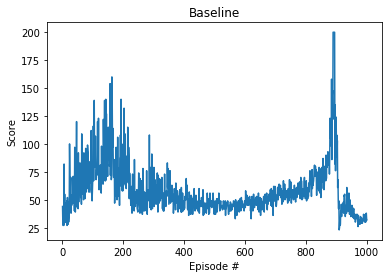

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(model)
plt.show()

### 5. Watch a Smart Agent!

In [71]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()